# Human action recognition

Within the field of computer vision, human action recognition (HAR) has emerged as a significant area of research. HAR focuses on the task of identifying and classifying human actions from static images or videos. This technology has a wide range of applications, including video surveillance systems, sports analysis software, and human-computer interaction interfaces.

For this project, we will develop two convolutional neural network (CNN) models to classify a dataset of images representing human actions. This dataset, titled "Human Action Recognition" is sourced from Kaggle and encompasses 15 distinct categories corresponding to everyday actions such as eating, sleeping, calling, and laughing.

We will implement two  different CNN models, namely ResNet50 and VGG16, that we will will train on the Human Action Recognition dataset. Finally, we will evaluate the performance of our models on a dedicated test set.


## Dataset configuration

In [ ]:
pip install d2l

In [ ]:
# Libraries
import os
import zipfile
import random
import shutil
import csv
import matplotlib.pyplot as plt
from PIL import Image
import d2l
from d2l import torch as d2l
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Kaggle API key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (4).json


{'kaggle (4).json': b'{"username":"chiarasangalli","key":"cf6d59fbd6b5412aff5114bd370ae743"}'}

In [ ]:
# Create the directory .kaggle and moving kaggle.json in it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading the HAR dataset from Kaggle
!kaggle datasets download -d meetnagadia/human-action-recognition-har-dataset

with zipfile.ZipFile('human-action-recognition-har-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/human-action-recognition-har-dataset')

Dataset URL: https://www.kaggle.com/datasets/meetnagadia/human-action-recognition-har-dataset
License(s): ODbL-1.0
human-action-recognition-har-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
dataset_path = '/content/human-action-recognition-har-dataset/Human Action Recognition/train'
selected_images_path = '/content/selected_images'

os.makedirs(selected_images_path, exist_ok=True)

In the initial stage of our project, we focus on data preparation: to ensure a representative sample for training our models, a subset of 7000 randomly selected images is extracted from the original dataset.


In [ ]:
# List of all the images in the train directory
all_images = []
for file in os.listdir(dataset_path):
    if file.lower().endswith(('.jpg', '.png', '.jpeg', '.gif', '.bmp', '.tiff')):
        all_images.append(os.path.join(dataset_path, file))

# Random selection of 7000 images
selected_images = random.sample(all_images, 7000)

for image in selected_images:
    shutil.copy(image, selected_images_path)

In [ ]:
print(f"Number of images contained in our dataset: {len(os.listdir(selected_images_path))}")

Number of images contained in our dataset: 12359


We proceed by splitting our dataset into 3 different subsets, namely trainining, validation and test set. This split is made to ensure that our human action recognition models are robust and generalizable.

The training set, made up of 5000 images is the largest portion and is used to teach the models how to identify different human actions in images.

The validation set, consistng 1000 images, acts as a checkpoint during training allowing us to monitor the model's performance and to prevent overfitting.

Finally, the test set (also made up of 1000 images) is completely independent of the training and validation processes. It provides a final evaluation of the model's ability to classify actions in completely new images, reflecting its generalizability.

In [ ]:
# Paths and directories definition
train_set_path = '/content/train_set'
validation_set_path = '/content/validation_set'
test_set_path = '/content/test_set'

os.makedirs(train_set_path, exist_ok=True)
os.makedirs(validation_set_path, exist_ok=True)
os.makedirs(test_set_path, exist_ok=True)

full_labels_file = '/content/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv'

In [ ]:
# Matching the images with their label
full_labels = {}
with open(full_labels_file, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        full_labels[row['filename']] = row['label']

all_images = os.listdir(selected_images_path)
random.shuffle(all_images)

def copy_images_with_labels(images, source_path, dest_path, labels):
    for image in images:
        if image in labels:
            label = labels[image]
            source_file = os.path.join(source_path, image)
            dest_file = os.path.join(dest_path, label, image)
            os.makedirs(os.path.join(dest_path, label), exist_ok=True)
            shutil.copy(source_file, dest_file)

In [ ]:
# Splitting the whole dataset into train, validation and test set
train_set = all_images[:5000]
remaining_images = all_images[5000:]
validation_set = remaining_images[:1000]
test_set = remaining_images[1000:2000]

copy_images_with_labels(train_set, selected_images_path, train_set_path, full_labels)
copy_images_with_labels(validation_set, selected_images_path, validation_set_path, full_labels)
copy_images_with_labels(test_set, selected_images_path, test_set_path, full_labels)

## Preliminary analysis

The following functions allow us to explore the structure and composition of our dataset: we define functions that enable us to verify the total number of images, analyze the distribution of images across different action classes, and visualize sample images for each class.

In [ ]:
# Useful functions to analyze the dataset's structure
def count_images_in_folder(folder_path):
    total_images = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
                total_images += 1
    return total_images

def count_images_by_class(root_path):
    class_folders = os.listdir(root_path)
    class_counts = {}

    for class_folder in class_folders:
        class_path = os.path.join(root_path, class_folder)
        if os.path.isdir(class_path):
            class_image_count = count_images_in_folder(class_path)
            class_counts[class_folder] = class_image_count

    return class_counts

def print_class_counts(root_path):
    class_folders = os.listdir(root_path)

    for class_folder in class_folders:
        class_path = os.path.join(root_path, class_folder)
        if os.path.isdir(class_path):
            class_image_count = count_images_in_folder(class_path)
            print(f"Class '{class_folder}' : {class_image_count}")

def find_image_in_class(class_path):
    for root, dirs, files in os.walk(class_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
                return os.path.join(root, file)
    return None

def show_images_by_class(root_path, num_images=15):
    class_folders = os.listdir(root_path)
    selected_images = {}

    for class_folder in class_folders:
        class_path = os.path.join(root_path, class_folder)
        if os.path.isdir(class_path):
            image_path = find_image_in_class(class_path)
            if image_path:
                selected_images[class_folder] = image_path

    num_cols = 5
    num_rows = (num_images // num_cols) + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i, (class_name, image_path) in enumerate(selected_images.items()):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        image = Image.open(image_path)
        ax.imshow(image)
        ax.set_title(class_name)
        ax.axis('off')

    for j in range(i + 1, num_rows * num_cols):
        row = j // num_cols
        col = j % num_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

To understand the distribution of images across each class of our dataset we print below the number of images for each action class within the training, validation, and test sets. It is clear that we are dealing with a very balanced dataset, where every class has almost the same amount of images of all the others.

In [ ]:
# Distribution across classes
print("Training set:")
print_class_counts(train_set_path)

print("\nValidation set:")
print_class_counts(validation_set_path)

print("\nTest set:")
print_class_counts(test_set_path)

Training set:
Class 'laughing' : 977
Class 'hugging' : 980
Class 'fighting' : 994
Class 'eating' : 1000
Class 'sleeping' : 1001
Class 'clapping' : 977
Class 'texting' : 990
Class 'using_laptop' : 992
Class 'cycling' : 992
Class 'running' : 984
Class 'calling' : 987
Class 'drinking' : 991
Class 'listening_to_music' : 971
Class 'dancing' : 981
Class 'sitting' : 995

Validation set:
Class 'laughing' : 261
Class 'hugging' : 288
Class 'fighting' : 310
Class 'eating' : 267
Class 'sleeping' : 271
Class 'clapping' : 271
Class 'texting' : 285
Class 'using_laptop' : 286
Class 'cycling' : 298
Class 'running' : 276
Class 'calling' : 295
Class 'drinking' : 291
Class 'listening_to_music' : 273
Class 'dancing' : 269
Class 'sitting' : 286

Test set:
Class 'laughing' : 275
Class 'hugging' : 289
Class 'fighting' : 271
Class 'eating' : 297
Class 'sleeping' : 294
Class 'clapping' : 278
Class 'texting' : 280
Class 'using_laptop' : 303
Class 'cycling' : 288
Class 'running' : 277
Class 'calling' : 265
Class 

Also the following pie chart visualizes a well-balanced training set, where the percentage of images for each action class falls within a narrow range, from a minimum of 6.1% to a maximum of 7.1%. A balanced training set ensures that the model receives adequate exposure to all action categories, leading to improved generalization and performance on unseen data.

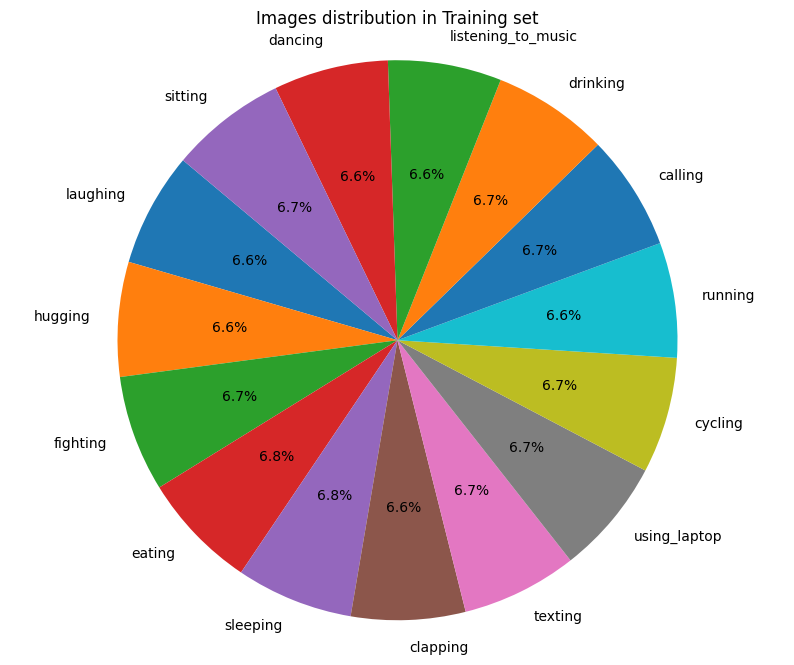

In [ ]:
# Pie chart
class_counts = count_images_by_class(train_set_path)
labels = list(class_counts.keys())
sizes = list(class_counts.values())

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Images distribution in Training set')
plt.axis('equal')
plt.show()

Below, we have represented one image for each class present in our dataset.

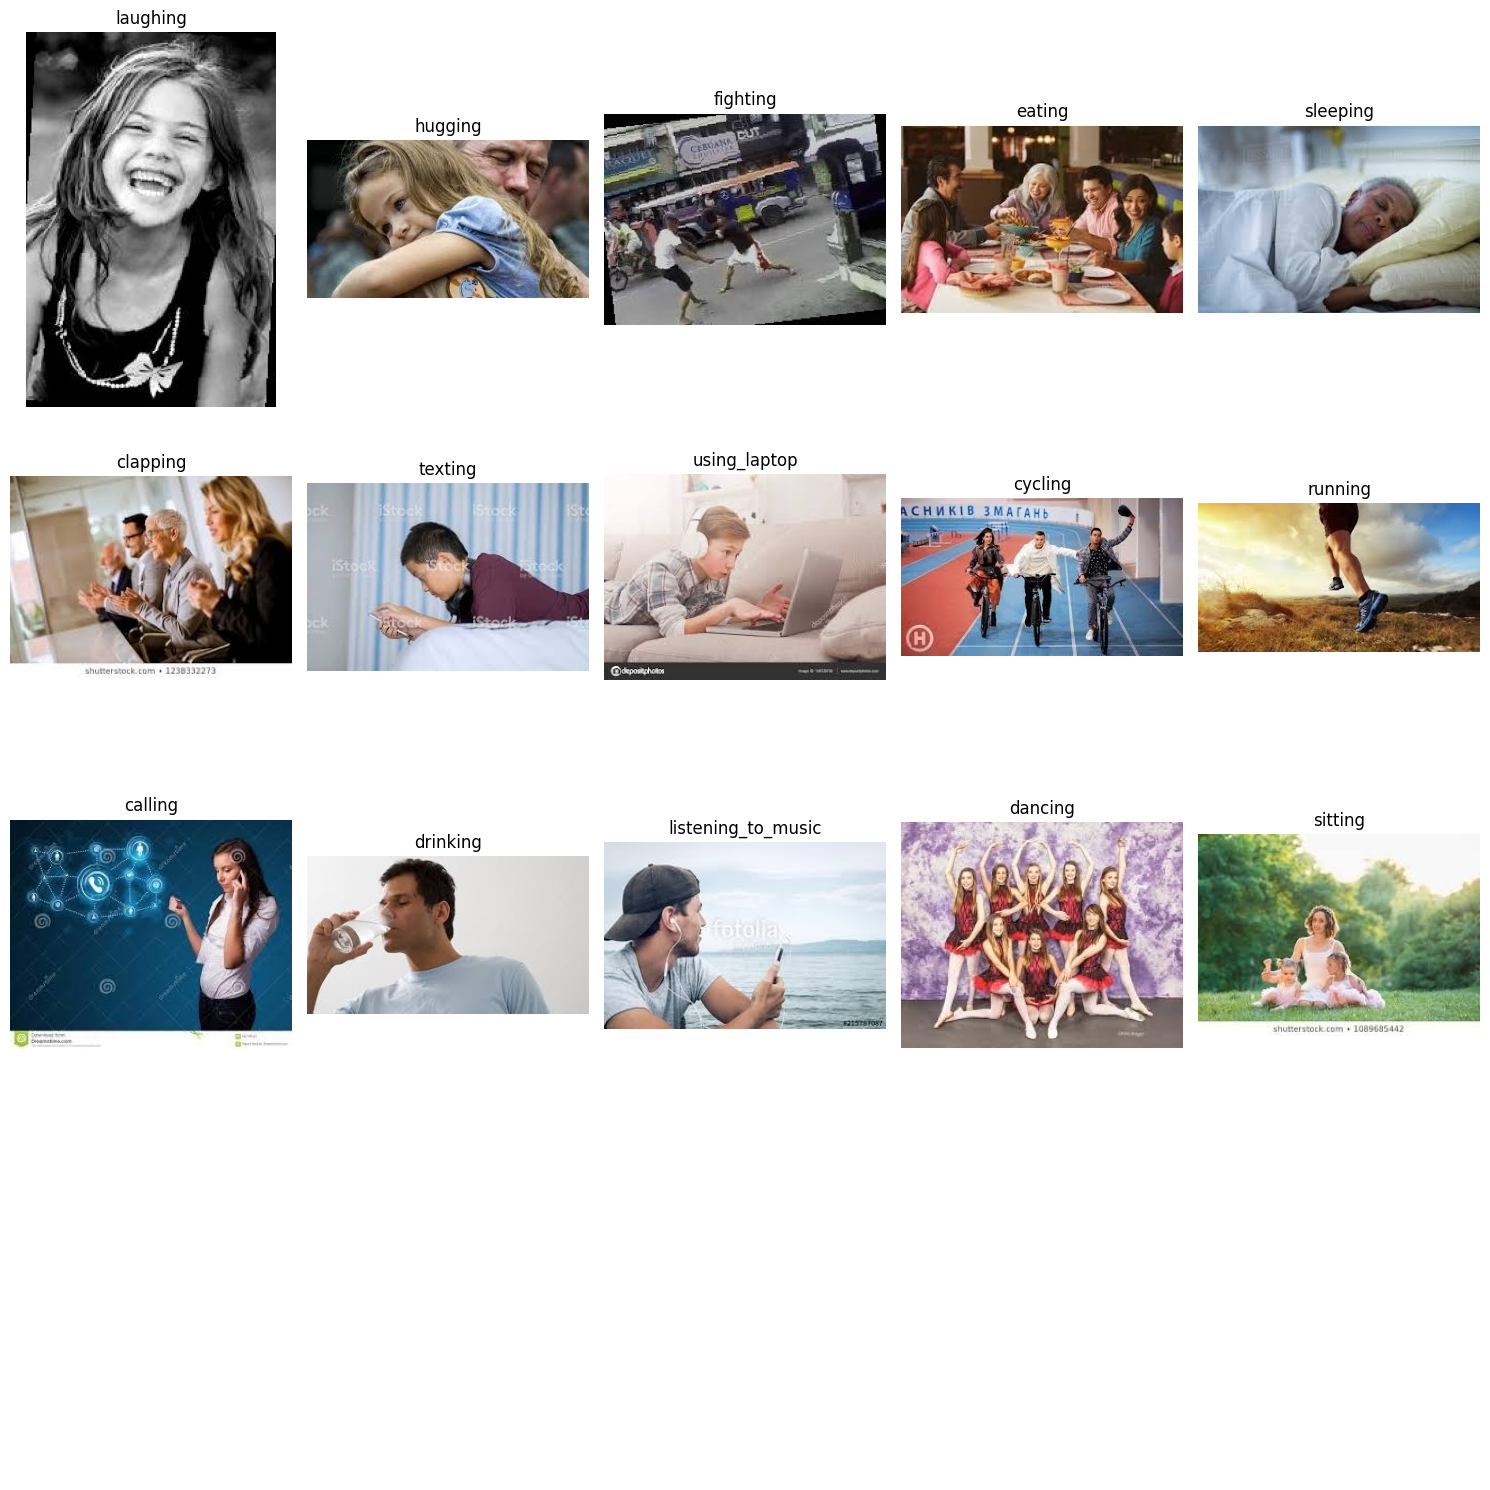

In [ ]:
show_images_by_class(train_set_path)

## Data augmentation

Data augmentation involves artificially creating new variations of existing images within a dataset: this process effectively expands the training data without the need for additional data collection.

We implement a function  that randomly selects a specified number of images from each class that will be subjected to a series of pre-defined transformations. These transformations include random rotations, horizontal flips, and slight color jittering.

By introducing these variations, the data augmentation process helps the model learn features that are more invariant to minor changes in the image, ultimately leading to a model that performs better on unseen data.

In [ ]:
# Function that performs data augmentation
def augment_and_save_images(folder_path, num_images_per_class):
    # Transformations applied to the images
    data_transform = transforms.Compose([
        transforms.RandomRotation(degrees=15),  # Random rotation
        transforms.RandomHorizontalFlip(p=0.5),  # Mirroring
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)  # Color change
    ])

    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            selected_images = random.sample(images, num_images_per_class)

            for image_name in selected_images:
                image_path = os.path.join(class_path, image_name)
                img = Image.open(image_path)

                augmented_img = data_transform(img)
                save_path = os.path.join(class_path, f"{os.path.splitext(image_name)[0]}_augmented.jpg")
                augmented_img.save(save_path)

In [ ]:
# Data augmentation
augment_and_save_images(train_set_path, 70)

In [ ]:
# Function to display augmented images
def show_augmented_images(folder_path, num_images_to_show=15):
    class_folders = [os.path.join(folder_path, class_folder) for class_folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, class_folder))]

    augmented_images = []

    for class_folder in class_folders:
        images = [os.path.join(class_folder, img) for img in os.listdir(class_folder) if 'augmented' in img]
        augmented_images.extend(images)

    selected_images = random.sample(augmented_images, num_images_to_show)

    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for ax, img_path in zip(axes.flatten(), selected_images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(os.path.basename(img_path), fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Below 15 aumgented images are displayed.

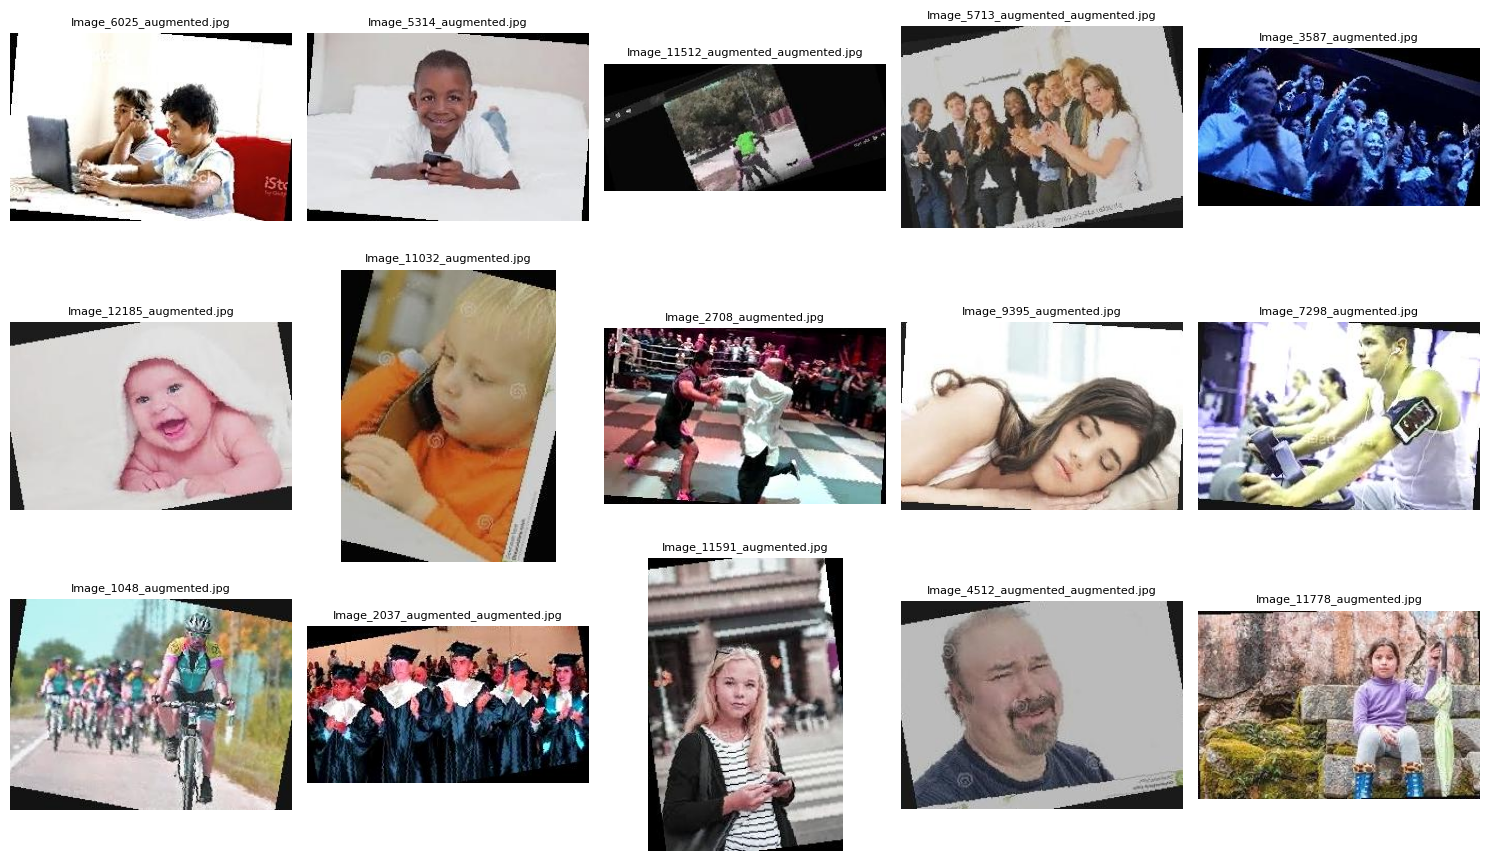

In [ ]:
show_augmented_images(train_set_path, 15)

## Data pre-processing

Prior to feeding our images into the deep learning models, we subject them to a series of essential transformations. This preprocessing step ensures the model can efficiently process the image data and achieve optimal performance.

We apply a sequence of transformations to each image:

* All images are resized to a uniform size of 224x224 pixels. This ensures consistency in the input data that the model expects.
* Images are converted from their original format into PyTorch tensors. Additionally, the pixel values are normalized to a range between 0 and 1, facilitating the training process.
* Normalization further standardizes the data distribution across all color channels (red, green, blue) by subtracting the mean and dividing by the standard deviation.


In [ ]:
# Images trasformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = datasets.ImageFolder('/content/train_set', transform=data_transform)
validation_dataset = datasets.ImageFolder('/content/validation_set', transform=data_transform)
test_dataset = datasets.ImageFolder('/content/test_set', transform=data_transform)

Following the image transformations, we create three distinct dataloaders: `train_loader`, `validation_loader`, and `test_loader`. These dataloaders play a critical role in training and testing our model. After different trials we decided to fix the parameter `batch_size` at 32.

In [ ]:
# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Below the functions `train` and `evaluate_accuracy_gpu` are defined: these functions will be used to train the model using the train and the validation set and to compute the accuracy on the test set, respectively.

In [ ]:
def train(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization: a particular method (see textbook section)
    net.apply(init_weights)
    print('training on', device)

    net.to(device) # MOVE the net to the GPU (if available)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.001)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode (not evaluation mode)

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #MOVE each minibatch of data to the GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # detach gradient calculation for avoiding effect on backpropagation calculation
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## VGG16

### Architecture

The first model we implement is a VGG16: the core of this architecture consists of five convolutional blocks, each one of them stacking multiple convolutional layers with filters of size 3x3, followed by Batch Normalization and ReLU activation

This process extracts features from the input image at increasing levels of complexity. Max pooling layers are inserted periodically between these blocks to reduce the spatial dimensions (height and width) of the feature maps while preserving the most important information.

After feature extraction, the network utilizes fully-connected layers to perform image classification. These layers take the flattened output from the convolutional blocks and learn relationships between the extracted features to classify the image into one of the 15 categories. Dropout layers are introduced between fully-connected layers to prevent overfitting.

In [ ]:
vgg16 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Dropout(0.65),
    nn.Linear(7*7*512, 4096),
    nn.ReLU(),
    nn.Dropout(0.65),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 15)
)

### Training stage

To achieve consistent and optimal results, we carefully tuned the learning rate and the number of training epochs. Through experimentation, we identified an efficient combination of these hyperparameters that yielded a training accuracy of X%, a testing accuracy of Y%, and a final loss function value of Z.

In [ ]:
num_epochs = 40
lr = 0.025
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
#train(vgg16, train_loader, validation_loader, num_epochs, lr) -- 30 0.02

### Test stage

We evaluated our trained CNN on unseen data from the test set, and it achieved an accuracy of X%. This result shows that our model developed a quite good generalization ability.

In [ ]:
#evaluate_accuracy_gpu(vgg16,test_loader) -- 30 0.02

In [ ]:
num_epochs = 40
lr = 0.025
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

loss 0.268, train acc 0.912, test acc 0.863
57.6 examples/sec on cuda:0


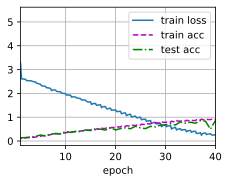

In [ ]:
train(vgg16, train_loader, validation_loader, num_epochs, lr)

In [ ]:
evaluate_accuracy_gpu(vgg16,test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0.8546442921295202

To further evaluate our VGG16 model's performance on unseen data, we utilized a classification report. This report analyzes the model's predictions for each class in the test set and provides metrics like precision, recall, and F1-score. Precision tells us the proportion of the model's predicted positives that were actually correct, while recall indicates how well the model identified true positive cases for each class. F1-score combines these metrics for a more balanced view. The report also provides support values, representing the total number of true instances for each class.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create iterator for test set
data_test_iter = iter(test_loader)
# Get first bacth of test set
samples, labels = next(data_test_iter)
# Move the input bacth on the GPU
samples = samples.to(device)

In [ ]:
# Perform prediction on the input batch on the GPU
output = vgg16(samples)

vgg16.eval()

pred = []
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        x = x.to(device)
        outputs = vgg16(x)
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       265
           1       0.85      0.84      0.84       278
           2       0.98      0.84      0.91       288
           3       0.84      0.89      0.87       268
           4       0.89      0.90      0.89       291
           5       0.89      0.94      0.92       297
           6       0.77      0.94      0.84       271
           7       0.93      0.88      0.90       289
           8       0.90      0.96      0.93       275
           9       0.73      0.88      0.80       252
          10       0.79      0.90      0.84       277
          11       0.90      0.69      0.78       303
          12       0.75      0.95      0.84       294
          13       0.88      0.75      0.81       280
          14       0.99      0.68      0.80       303

    accuracy                           0.85      4231
   macro avg       0.86      0.86      0.85      4231
weighted avg       0.87   

Moreover we plot the confusion matrix that compares the true labels of the data with the predictions made by our model.

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="BuPu", values_format=".2f", ax=ax, colorbar=False)

    plt.xticks(rotation=90)

    plt.title("Normalized confusion matrix")
    ax.grid(False)
    plt.show()

categories = ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening-to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']

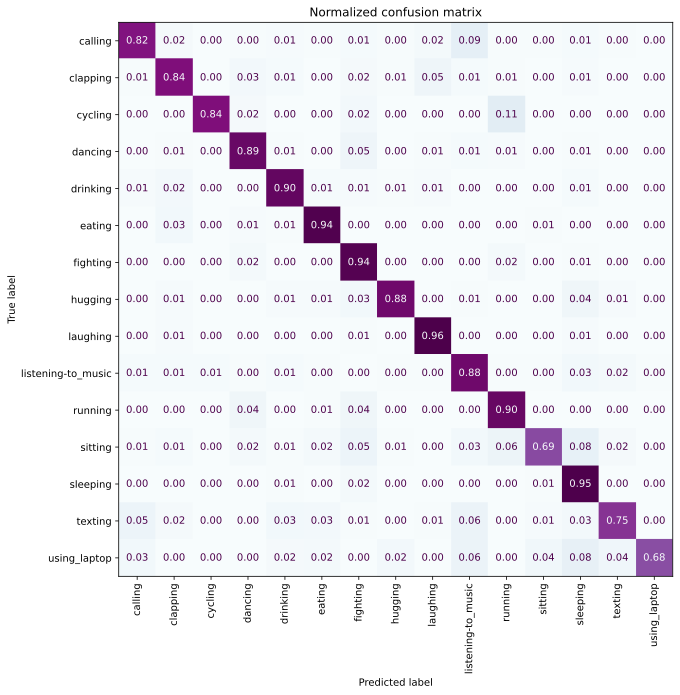

In [ ]:
# Confusion matrix
plot_confusion_matrix(pred, Y, categories)

## ResNet

### Architecture

The second model we implement to classify the images in the HAR dataset is a residual network.

ResNet architecture leverages residual blocks for improved performance: the `ResidualBlock `class represents the fundamental building block of the network. It takes an input, performs two convolutional layers with batch normalization and ReLu activation functions in between, and allows for a shortcut connection with the original input. This shortcut is particularly important in residual networks as it helps address the vanishing gradient problem that can hinder training deeper networks. The class also allows for downsampling the input through an additional convolutional layer within the shortcut connection if needed.

The second class, `ResNetModule`, builds upon the `ResidualBlock` by stacking two consecutive residual blocks: it takes an input, passes it through two `ResidualBlock` instances, and returns the final output. This allows for creating more complex feature hierarchies within the network.

Finally, `ResNet` defines the overall architecture of the ResNet model: this class takes the input image, performs an initial convolution and pooling to reduce dimensionality, and then stacks four `ResNetModule` instances with increasing feature channel depths and downsampling rates. Finally, it uses global average pooling to reduce the spatial dimensions to a single value per channel and a fully-connected layer for classification.


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        out = self.dropout(out)

        return out

In [ ]:
class ResNetModule(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.5):
        super(ResNetModule, self).__init__()

        # First block
        self.block1 = ResidualBlock(in_channels, out_channels, stride=1, dropout_rate=dropout_rate)

        # Second block with downsampling
        self.block2 = ResidualBlock(out_channels, out_channels, stride=stride, dropout_rate=dropout_rate)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ResNetModule(64, 64, stride=1, dropout_rate=dropout_rate)
        self.layer2 = ResNetModule(64, 128, stride=2, dropout_rate=dropout_rate)
        self.layer3 = ResNetModule(128, 256, stride=2, dropout_rate=dropout_rate)
        self.layer4 = ResNetModule(256, 512, stride=2, dropout_rate=dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
resnet = ResNet(num_classes = 15, dropout_rate = 0.5).to(device)

### Training stage

Also for this second model we carefully fined-tuned the parameters `lr` and `num_epochs`: our final CNN yelds a final training loss equal to 1.344 while the trainig and the test accuracy are of 56% and 60% respectively.

In [ ]:
lr2 = 0.05
num_epochs2 = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss 1.344, train acc 0.563, test acc 0.604
151.4 examples/sec on cuda


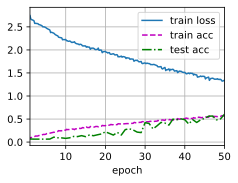

In [ ]:
train(resnet, train_loader, validation_loader, num_epochs2, lr2, device=device)

### Test stage

The accuracy scored by our ResNet on the test set is equal to 60% suggesting that our model developed a limited capability at correctly classifying images.

In [ ]:
evaluate_accuracy_gpu(resnet, test_loader)

0.6043488536988891

Also for this second model we report the classification report and the confusion matrix.

In [ ]:
# Create iterator for test set
data_test_iter = iter(test_loader)
# Get first bacth of test set
samples, labels = next(data_test_iter)
# Move the input bacth on the GPU
samples = samples.to(device)

# Perform prediction on the input batch on the GPU
output = resnet(samples)

resnet.eval()

pred = []
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        x = x.to(device)
        outputs = resnet(x)
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       0.57      0.52      0.54       265
           1       0.79      0.39      0.52       278
           2       0.79      0.94      0.86       288
           3       0.74      0.62      0.68       268
           4       0.45      0.64      0.53       291
           5       0.94      0.63      0.76       297
           6       0.48      0.83      0.61       271
           7       0.63      0.42      0.51       289
           8       0.58      0.71      0.64       275
           9       0.75      0.27      0.39       252
          10       0.79      0.69      0.74       277
          11       0.46      0.51      0.49       303
          12       0.79      0.68      0.73       294
          13       0.47      0.42      0.44       280
          14       0.45      0.76      0.57       303

    accuracy                           0.60      4231
   macro avg       0.65      0.60      0.60      4231
weighted avg       0.64   

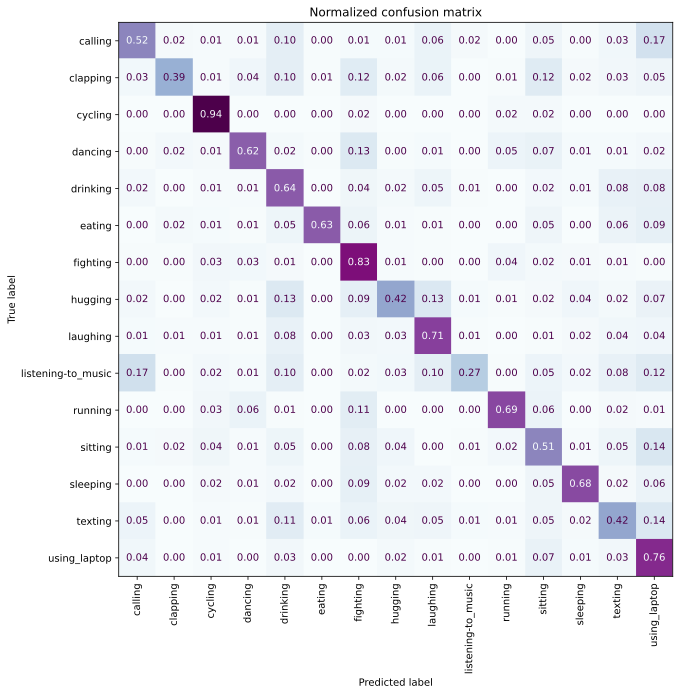

In [ ]:
# Confusion matrix
plot_confusion_matrix(pred, Y, categories)

The accuracy of our ResNet model varies across different classes: for instance, it excels at classifying images of people cycling, achieving 91% accuracy, but struggles with identifying pictures of someone listening to music, reaching only 27% accuracy.